# Create a dataset of faces dividing them in fake and real

### Libraries, constants and pre-trained MTCNN

Install FaceNet-PyTorch if it's not already installed (it includes the pre-trained MTCNN model):

In [26]:
!pip install facenet-pytorch Pillow

Import the necessary libraries:

In [31]:
import numpy as np
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from random import randint
from PIL import Image

In [23]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


Import the pre-trained MTCNN:

[Guide on how to use MTCNN](https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch/notebook)

In [27]:
from facenet_pytorch import MTCNN, extract_face

Constants:

In [4]:
DATA_FOLDER = "../data/"
ORIGINAL_VIDEOS_FOLDER = os.path.join(
    DATA_FOLDER, "original_sequences", "actors", "c40", "videos"
)
FAKE_VIDEOS_FOLDER = os.path.join(
    DATA_FOLDER, "manipulated_sequences", "DeepFakeDetection", "c40", "videos"
)

Lists of fake and real videos:

In [5]:
ORIGINAL_VIDEOS = os.listdir(ORIGINAL_VIDEOS_FOLDER)
FAKE_VIDEOS = os.listdir(FAKE_VIDEOS_FOLDER)

### Plot some examples

post_process avoids image normalization to be able to plot the images:

In [28]:
# Load the MTCNN in evaluation mode
# -> Evaluation deactivates Dropout layers, which speeds up the inference
mtcnn = MTCNN(select_largest=False, post_process=False, device=device).eval()

In [33]:
def plot_example(num_samples=3):
    """Plot the first frame of fake video and the extracted face"""
    _, ax = plt.subplots(nrows=num_samples, ncols=2, figsize=(18, 10))
    
    for i in range(num_samples):
        video_idx = randint(0, len(FAKE_VIDEOS)-1)

        # Fake video
        fake_video = cv2.VideoCapture(
            os.path.join(FAKE_VIDEOS_FOLDER, FAKE_VIDEOS[video_idx]
        ))
        # Get the first frame
        _, fake_frame = fake_video.read()
        # BGR -> RGB
        fake_frame = cv2.cvtColor(fake_frame, cv2.COLOR_BGR2RGB)

        # Convert the image frame to a numpy array
        frame_array = Image.fromarray(fake_frame)
        face = mtcnn(frame_array)

        # After being processed by MTCNN, the face has the shape: (CHANNELS, HEIGHT, WIDTH)
        # we have to change the change so that it has the shape (HEIGHT, WIDTH, CHANNELS)
        face = face.permute(1, 2, 0)

        # Remember that the output of the model is a tensor where the pixel values are float values
        # To be able to plot the face, we have to convert it into a numpy array of integer values
        #
        # If the image is in the GPU, we also have to move it to the CPU
        face = face.cpu().detach().int().numpy()

        # Plot the frames
        ax[i, 0].imshow(fake_frame)
        ax[i, 1].imshow(face)
        ax[i, 0].set_title("Fake (full image)")
        ax[i, 1].set_title("Fake (face)")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

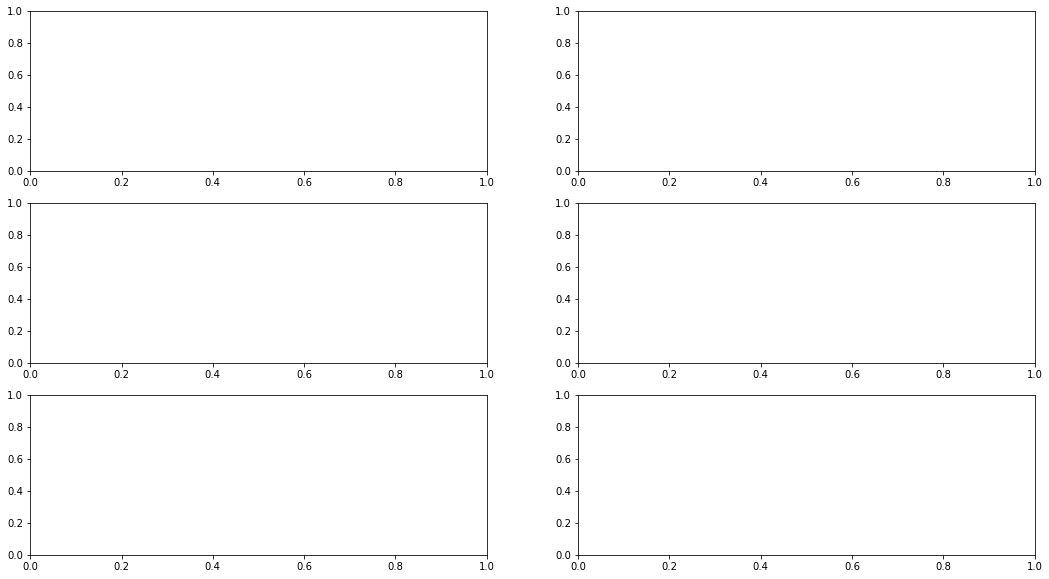

In [34]:
plot_example()

In [35]:
print(torch.__path__)
print(torchvision.__path__)

['/Users/aaron/miniforge3/envs/torch4arm/lib/python3.9/site-packages/torch']
['/Users/aaron/miniforge3/envs/torch4arm/lib/python3.9/site-packages/torchvision']
